In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
np.set_printoptions(precision=3,suppress=True)

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [37]:
# --- DATA LOADING (online) + OFFLINE FALLBACK (synthetic) ---
# Ten notebook oryginalnie pobiera Auto MPG z UCI. W środowiskach bez internetu pojawia się błąd "brak źródła".
# Poniżej jest bezpieczny fallback: jeśli pobranie się nie uda, generujemy syntetyczny zbiór o podobnej strukturze.

import numpy as np
import pandas as pd

def make_synthetic_auto_mpg(n: int = 398, seed: int = 42) -> pd.DataFrame:
    rng = np.random.default_rng(seed)

    # Zmienne dyskretne
    cylinders = rng.choice([3, 4, 5, 6, 8], size=n, p=[0.02, 0.5, 0.03, 0.25, 0.20])
    model_year = rng.integers(70, 83, size=n)  # 70..82
    origin = rng.choice(["USA", "Europe", "Japan"], size=n, p=[0.62, 0.18, 0.20])

    # Displacement rośnie z cylindrami
    displacement = (
        cylinders * rng.normal(35, 6, size=n)
        + rng.normal(40, 25, size=n)
    )
    displacement = np.clip(displacement, 60, 460)

    # Horsepower zależny od displacement i cyl
    horsepower = (
        0.35 * displacement
        + 6 * (cylinders - 4)
        + rng.normal(0, 18, size=n)
    )
    horsepower = np.clip(horsepower, 45, 240)

    # Weight zależny od displacement i origin
    origin_weight_shift = np.select(
        [origin == "USA", origin == "Europe", origin == "Japan"],
        [250, -120, -80],
        default=0
    )
    weight = (
        8.5 * displacement
        + origin_weight_shift
        + rng.normal(0, 250, size=n)
        + 100 * (cylinders - 4)
    )
    weight = np.clip(weight, 1500, 5200)

    # Acceleration: większa masa = zwykle gorsze przyspieszenie (większy czas)
    acceleration = (
        22 - 0.0018 * weight + rng.normal(0, 1.2, size=n)
    )
    acceleration = np.clip(acceleration, 8, 25)

    # MPG: spada z masą/horsepower/displacement, rośnie z rokiem modelowym (postęp technologiczny)
    origin_eff = np.select(
        [origin == "USA", origin == "Europe", origin == "Japan"],
        [0.0, 2.2, 2.8],
        default=0.0
    )
    mpg = (
        58
        - 0.0048 * weight
        - 0.045 * horsepower
        - 0.010 * displacement
        + 0.55 * (model_year - 70)
        + origin_eff
        + rng.normal(0, 2.2, size=n)
    )
    mpg = np.clip(mpg, 8, 50)

    df = pd.DataFrame({
        "MPG": mpg.round(2),
        "Cylinders": cylinders.astype(int),
        "Displacement": displacement.round(1),
        "Horsepower": horsepower.round(1),
        "Weight": weight.round(1),
        "Acceleration": acceleration.round(2),
        "Model Year": model_year.astype(int),
        "Origin": origin
    })
    return df

def load_auto_mpg() -> pd.DataFrame:
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
    column_names = ["MPG","Cylinders","Displacement","Horsepower","Weight","Acceleration","Model Year","Origin"]

    try:
        raw = pd.read_csv(
            url,
            names=column_names,
            na_values="?",
            comment="\t",
            sep=" ",
            skipinitialspace=True,
        )
        ds = raw.copy().dropna()
        # origin w oryginale jest kodem 1/2/3
        if ds["Origin"].dtype != object:
            ds["Origin"] = ds["Origin"].map({1: "USA", 2: "Europe", 3: "Japan"})
        return ds
    except Exception as e:
        print("⚠️ Nie udało się pobrać danych z internetu. Używam syntetycznego zbioru Auto MPG.")
        print("   Powód:", repr(e))
        return make_synthetic_auto_mpg()

dataset = load_auto_mpg()
dataset.head()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,USA
1,15.0,8,350.0,165.0,3693.0,11.5,70,USA
2,18.0,8,318.0,150.0,3436.0,11.0,70,USA
3,16.0,8,304.0,150.0,3433.0,12.0,70,USA
4,17.0,8,302.0,140.0,3449.0,10.5,70,USA


In [38]:
# (dane wczytane w poprzedniej komórce)


In [39]:
dataset.tail()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,USA
394,44.0,4,97.0,52.0,2130.0,24.6,82,Europe
395,32.0,4,135.0,84.0,2295.0,11.6,82,USA
396,28.0,4,120.0,79.0,2625.0,18.6,82,USA
397,31.0,4,119.0,82.0,2720.0,19.4,82,USA


In [40]:
dataset.isna().sum()

,0
MPG,0
Cylinders,0
Displacement,0
Horsepower,0
Weight,0
Acceleration,0
Model Year,0
Origin,0


In [41]:
# dataset = dataset.dropna()  # (opcjonalnie) - u nas już bez braków


In [42]:
dataset.isna().sum()

,0
MPG,0
Cylinders,0
Displacement,0
Horsepower,0
Weight,0
Acceleration,0
Model Year,0
Origin,0


In [43]:
# Origin bywa kodem 1/2/3 (UCI) albo tekstem (nasz fallback).
if dataset["Origin"].dtype != object:
    dataset["Origin"] = dataset["Origin"].map({1:"USA", 2:"Europe", 3:"Japan"})
dataset["Origin"].value_counts()


,count
Origin,
USA,245
Japan,79
Europe,68


In [44]:
dataset = pd.get_dummies(dataset,columns=['Origin'],prefix='',prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,False,False,True
394,44.0,4,97.0,52.0,2130.0,24.6,82,True,False,False
395,32.0,4,135.0,84.0,2295.0,11.6,82,False,False,True
396,28.0,4,120.0,79.0,2625.0,18.6,82,False,False,True
397,31.0,4,119.0,82.0,2720.0,19.4,82,False,False,True


In [45]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

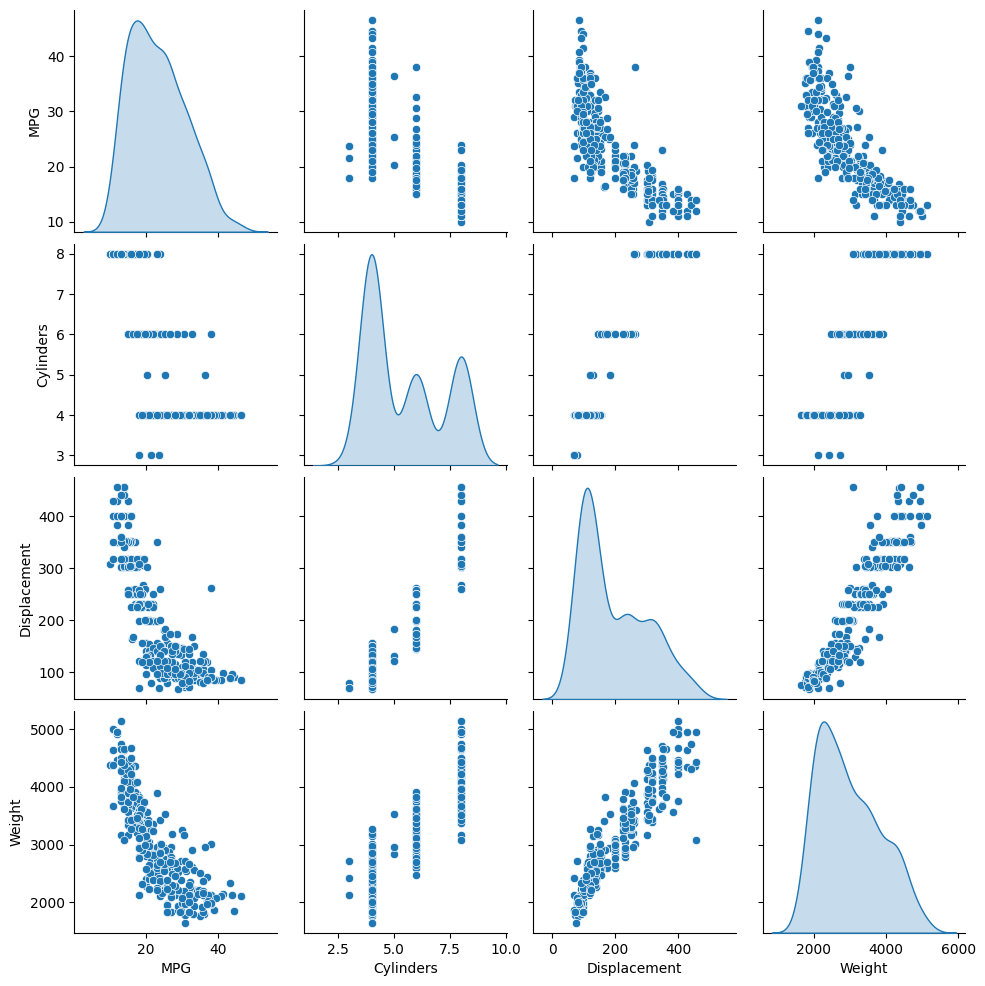

In [46]:
sns.pairplot(train_dataset[['MPG','Cylinders','Displacement','Weight']],diag_kind='kde')

In [47]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0


In [48]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [49]:
train_dataset.describe().transpose()[['mean','std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642


In [50]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [51]:
normalizer.adapt(np.array(train_features))

In [52]:
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


In [53]:
first = np.array(train_features[:1])

In [54]:
with np.printoptions(precision=2,suppress=True):
    print(f'pierwszy przypadek: {first}')
    print(f'po normalizacji: {normalizer(first.astype(float)).numpy()}')

pierwszy przypadek: [[4 90.0 75.0 2125.0 14.5 74 False False True]]
po normalizacji: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


In [55]:
#regresja liniowa z jedną zmienną
#y = ax+b

horsepower = np.array(train_features['Horsepower'])
horsepower_normalizer = layers.Normalization(input_shape=[1,],axis=None)
horsepower_normalizer.adapt(horsepower)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [56]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_3 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5 (24.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 3 (16.00 B)

In [57]:
horsepower_model.predict(horsepower[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


array([[ 1.189],
       [ 0.671],
       [-2.194],
       [ 1.666],
       [ 1.507],
       [ 0.592],
       [ 1.786],
       [ 1.507],
       [ 0.393],
       [ 0.671]], dtype=float32)

In [58]:
horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

In [59]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    verbose=0,
    validation_split=0.2
)

CPU times: user 12.6 s, sys: 529 ms, total: 13.1 s
Wall time: 13.7 s


In [60]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.808558,4.203711,95
96,3.803994,4.193376,96
97,3.804693,4.190407,97
98,3.804470,4.189939,98
99,3.802944,4.200694,99


In [61]:
import matplotlib.pyplot as plt

In [62]:
def plot_loss(history):
    plt.plot(history.history['loss'],label='loss')
    plt.plot(history.history['val_loss'],label='val_loss')
    plt.ylim([0,10])
    plt.xlabel('Epoch')
    plt.ylabel('Error[MPG]')
    plt.legend()
    plt.grid(True)

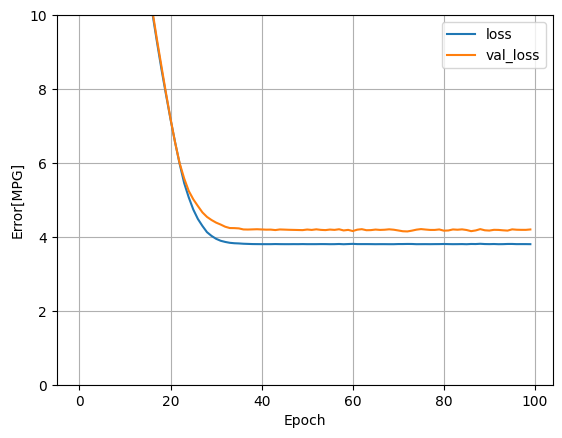

In [63]:
plot_loss(history)

In [64]:
test_result = {}
test_result['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels,
    verbose=0
)

In [65]:
x = tf.linspace(0.0,250,251)
y = horsepower_model.predict(x)

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [66]:
def plot_horsepower(x,y):
    plt.scatter(train_features['Horsepower'],train_labels,label='Data')
    plt.plot(x,y,color='k',label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

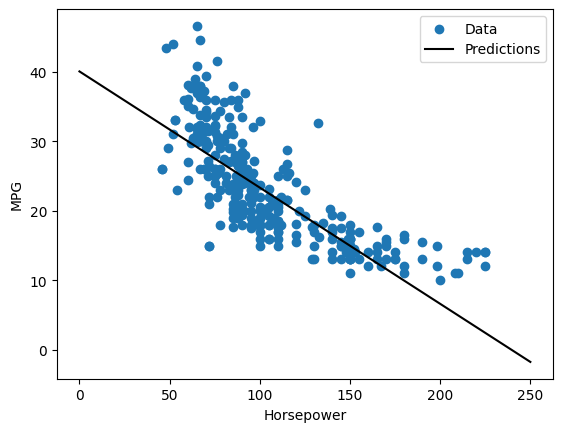

In [67]:
plot_horsepower(x,y)

In [68]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])
linear_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_2 (Normalization) │ (314, 9)               │            19 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19 (80.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19 (80.00 B)

In [69]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

In [70]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    verbose=0,
    validation_split=0.2
)

CPU times: user 13.8 s, sys: 549 ms, total: 14.4 s
Wall time: 15.1 s


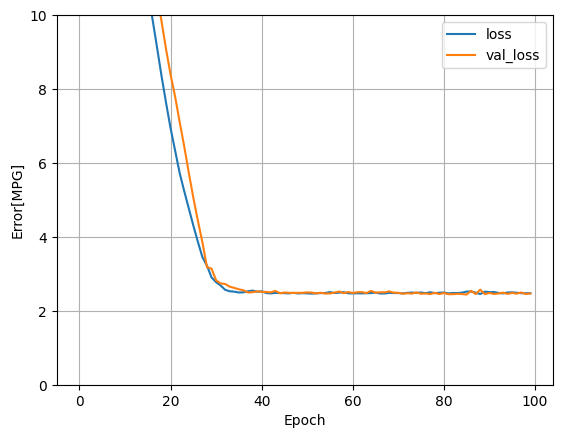

In [71]:
plot_loss(history)

In [72]:
test_result['linear_model'] = linear_model.evaluate(
    test_features,
    test_labels,
    verbose=0
)

In [73]:
#regresja z głędoką siecią neuronową DNN
def build_and_compile(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64,activation='relu'),
        layers.Dense(64,activation='relu'),
        layers.Dense(1)
    ])
    model.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [74]:
#regresja z użyciem DNN i pojedynczego wejścia
dnn_horsepower_model = build_and_compile(horsepower_normalizer)

In [75]:
dnn_horsepower_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_3 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,356 (17.02 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 3 (16.00 B)

In [76]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    verbose=0,
    validation_split=0.2
)

CPU times: user 17.4 s, sys: 741 ms, total: 18.1 s
Wall time: 19.9 s


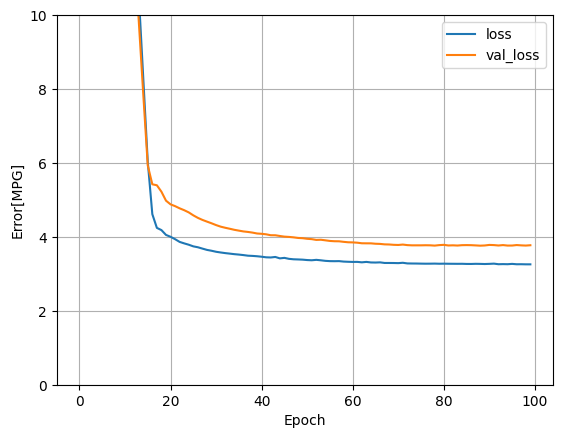

In [77]:
plot_loss(history)

In [78]:
test_result['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels,
    verbose=0
)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


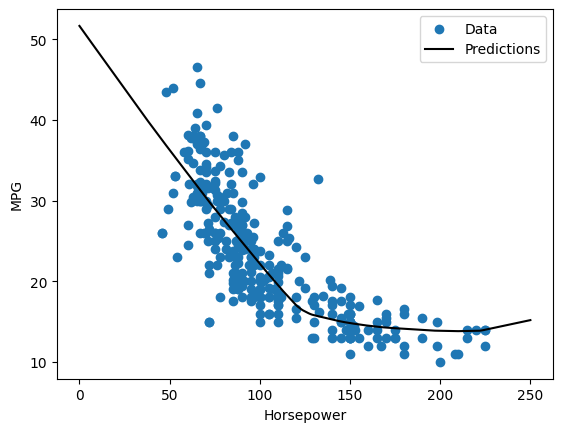

In [79]:
x = tf.linspace(0.0,250,251)
y = dnn_horsepower_model.predict(x)
plot_horsepower(x,y)

In [80]:
#regresja przy użyciu dnn i wielu danych wejściowych
dnn_model = build_and_compile(normalizer)
dnn_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_2 (Normalization) │ (None, 9)              │            19 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19 (80.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19 (80.00 B)

In [81]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    epochs=100,
    verbose=0,
    validation_split=0.2
)

CPU times: user 15.1 s, sys: 670 ms, total: 15.7 s
Wall time: 16.4 s


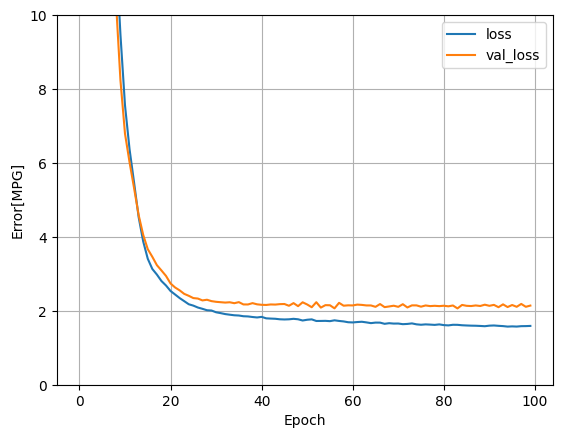

In [82]:
plot_loss(history)

In [83]:
test_result['dnn_model'] = dnn_model.evaluate(
    test_features,
    test_labels,
    verbose=0
)

In [84]:
#regresja z głędoką siecią neuronową DNN
def build_and_compile_biggest(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(128,activation='relu'),
        layers.Dense(512,activation='relu'),
        layers.Dense(512,activation='relu'),
        layers.Dense(64,activation='relu'),
        layers.Dense(1)
    ])
    model.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [85]:
#regresja przy użyciu dnn - z większą ilością warstw i wielu danych wejściowych
dnn_model_big = build_and_compile_biggest(normalizer)
dnn_model_big.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_2 (Normalization) │ (None, 9)              │            19 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19 (80.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19 (80.00 B)

In [86]:
%%time
history = dnn_model_big.fit(
    train_features,
    train_labels,
    epochs=100,
    verbose=0,
    validation_split=0.2
)

CPU times: user 22.4 s, sys: 991 ms, total: 23.4 s
Wall time: 20.8 s


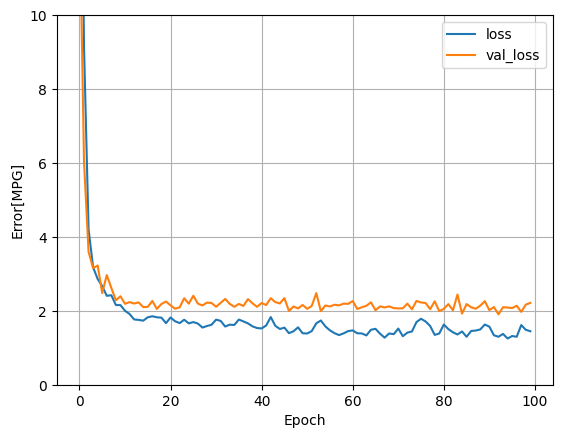

In [87]:
plot_loss(history)

In [88]:
test_result['dnn_model_big'] = dnn_model_big.evaluate(
    test_features,
    test_labels,
    verbose=0
)

In [89]:
pd.DataFrame(test_result,index=['Mean absolute Error [MPG]']).T

,Mean absolute Error [MPG]
horsepower_model,3.662409
linear_model,2.486982
dnn_horsepower_model,2.910992
dnn_model,1.719636
dnn_model_big,1.876430
